In [1]:
import os; os.environ['XLA_PYTHON_CLIENT_MEM_FRACTION']='1.' # NOTE: jax preallocates GPU (default 75%)
from pathlib import Path
import numpy as np
from functools import partial
import matplotlib.pyplot as plt
from jax import numpy as jnp, random as jr, config as jconfig, devices as jdevices, jit, vmap, pmap, grad, debug, tree, lax, value_and_grad
jconfig.update("jax_enable_x64", True)
print(jdevices())

%matplotlib inline
%load_ext autoreload
%autoreload 2
!hostname
#!jupyter nbconvert --to python /dvs_ro/u1/h/hsimfroy/workspace/montecosmo_proj/src/montecosmo/tests/infer_model2.ipynb

# save_dir = Path("./save/")
# save_dir = Path(os.path.expanduser("~/scratch/png/abacus_c0_i0_z08_lrg/test")) # FMN
# load_dir = Path(os.path.expanduser("~/scratch/png/abacus_c0_i0_z08_lrg/load/")) # FMN
# save_dir = Path("/lustre/fsn1/projects/rech/fvg/uvs19wt/png/") # JZ
# save_dir = Path("/lustre/fswork/projects/rech/fvg/uvs19wt/workspace/png/") # JZ
save_dir = Path("/pscratch/sd/h/hsimfroy/png/abacus_c0_i0_z0.8_lrg/noise") # Perlmutter
load_dir = Path("/pscratch/sd/h/hsimfroy/png/abacus_c0_i0_z0.8_lrg/load/") # Perlmutter
# load_dir = Path("/pscratch/sd/h/hsimfroy/png/fpm_b2760_z1_lrg_fNL/load/") # Perlmutter
# save_path = save_dir / "test"
# save_dir.mkdir(parents=True, exist_ok=True)

[CudaDevice(id=0), CudaDevice(id=1), CudaDevice(id=2), CudaDevice(id=3)]
nid001136


/global/u1/h/hsimfroy/miniforge3/envs/montenv/lib/python3.14/pty.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


In [8]:
from montecosmo.model import FieldLevelModel, default_config
from montecosmo.utils import pdump, pload , chreshape, r2chshape, boxreshape, rg2cgh, cgh2rg
from montecosmo.bricks import top_hat_selection, gen_gauss_selection
from tqdm import tqdm

box_size = 3*(2000,)
mesh_length = 64
z_obs = 0.8

model = FieldLevelModel(**default_config | 
                        {'final_shape': 3*(mesh_length,), 
                        'cell_length': box_size[0] / mesh_length, # in Mpc/h
                        # 'box_center': (0.,0.,0.), # in Mpc/h
                        'box_center': (0.,0.,1938.), # in Mpc/h # a2chi(model.cosmo_fid, a=1/(1+z_obs))

                        'box_rotvec': (0.,0.,0.,), # rotation vector in radians
                        # 'evolution': 'lpt',
                        'evolution': 'kaiser',
                        'nbody_n_steps':10,
                        'nbody_a_start':1 / (1 + 10),

                        'a_obs': 1 / (1 + z_obs), # light-cone if None
                        'curved_sky': False, # curved vs. flat sky
                        'ap_auto': None, # parametrized AP vs. auto AP
                        'selection': None, # if float, padded fraction, if str or Path, path to window mesh file
                        'paint_order':2, # order of interpolation kernel
                        'paint_deconv': True, # whether to deconvolve painted field
                        'kernel_type':'rectangular', # 'rectangular', 'kaiser_bessel'
                        'init_oversamp':1.5, # initial mesh 1D oversampling factor
                        'evol_oversamp':2., # evolution mesh 1D oversampling factor
                        'ptcl_oversamp':2., # particle cloud 1D oversampling factor
                        'paint_oversamp':2., # painted mesh 1D oversampling factor

                        # 'init_oversamp':1.5, # initial mesh 1D oversampling factor
                        # 'evol_oversamp':1.5, # evolution mesh 1D oversampling factor
                        # 'ptcl_oversamp':1.5, # particle cloud 1D oversampling factor
                        # 'paint_oversamp':1.5, # painted mesh 1D oversampling factor

                        # 'init_oversamp':1., # initial mesh 1D oversampling factor
                        # 'evol_oversamp':1., # evolution mesh 1D oversampling factor
                        # 'ptcl_oversamp':1., # particle cloud 1D oversampling factor
                        # 'paint_oversamp':1., # painted mesh 1D oversampling factor
                        'interlace_order':2, # interlacing order
                        'n_rbins': 1,
                        'k_cut': np.inf,
                        'init_power': load_dir / f'init_kpow.npy',
                        # 'init_power': None,
                        'lik_type': 'gaussian_delta',
                        # 'lik_type': 'gaussian_fourier',
                        'png_type': 'fNL_bias',
                        } )

truth = {
    'Omega_m': 0.3137721, 
    'sigma8': 0.8076353990239834,
    'b1': 0.7,
    'b2': 0.,
    'bs2': 0.,
    'bn2': 0.,
    'bnpar': 0.,

    'b1': 1.15,
    'b2': 0.2,
    'bs2': -0.2,

    'b3': 0.,
    'fNL': 0.,
    'fNL_bp':0.,
    'fNL_bpd':0.,
    'alpha_iso': 1.,
    'alpha_ap': 1.,
    # 'ngbars': 8.43318125e-4,
    # 'ngbars': 1e-4,
    'ngbars': 1e5, # neglect lik noise
    's_0': 0.5,
    's_2': 0.,
    's_2mu': 0.,
    's_delta': 0.7,
    's_phi': 0.,
    }


latents = model.new_latents_from_loc(truth)
model = FieldLevelModel(**model.asdict() | {'latents': latents})
print(model)
# model.render()

# Abacus matter
# obs_mesh = jnp.load(load_dir / f'fin_paint2_interl2_deconv0_{mesh_length}.npy')
# obs_mesh = jnp.load(load_dir / f'fin_paint2_interl1_deconv1_{mesh_length}.npy')
# obs_mesh = jnp.load(load_dir / f'fin_paint2_interl2_deconv1_{mesh_length}.npy')

# Abacus tracer real or redshift-space
# obs_mesh = jnp.load(load_dir / f'tracer_6746545_paint2_deconv1_{mesh_length}.npy')
obs_mesh = jnp.load(load_dir / f'tracer_6746545_rsdflat_paint2_deconv1_{mesh_length}.npy')
obs_mesh *= truth['ngbars'] * model.cell_length**3


# Abacus initial
init_mesh = jnp.fft.rfftn(jnp.load(load_dir / f'init_mesh_{576}.npy'))
init_mesh = chreshape(init_mesh, r2chshape(model.init_shape))
truth0 = truth | {'init_mesh': init_mesh} | {'obs': obs_mesh}
del obs_mesh
del init_mesh
truth |= {'init_mesh': truth0['init_mesh']}

delta0 = model.count2delta(truth0['obs'])
kpow0 = model.spectrum(delta0)
delta_sims = []
kptcs = []

truths = []
confs = []
truths.append(truth)
confs.append({})
truths.append(truth)
# confs.append({'evolution': 'lpt', 'lpt_order': 1,})
# truths.append(truth)
confs.append({'evolution': 'lpt', 'lpt_order': 2,})
# truths.append(truth)
# confs.append({'evolution': 'nbody', 'lpt_order': 2,})


for tr, conf in tqdm(zip(truths, confs)):
    model = FieldLevelModel(**model.asdict() | conf)
    sim = model.predict(samples=truth | tr, hide_base=False, hide_samp=False, from_base=True)
    delta_sim = model.count2delta(sim['obs'])
    delta_sims.append(delta_sim)

    kptc = model.powtranscoh(delta0, delta_sim)
    kptcs.append(kptc)


# CONFIG
{'a_obs': 0.5555555555555556,
 'ap_auto': None,
 'box_center': array([   0.,    0., 1938.]),
 'box_rotvec': array([0., 0., 0.]),
 'cell_length': 31.25,
 'curved_sky': False,
 'evol_oversamp': 2.0,
 'evolution': 'kaiser',
 'final_shape': array([64, 64, 64]),
 'init_oversamp': 1.5,
 'init_power': '/pscratch/sd/h/hsimfroy/png/abacus_c0_i0_z0.8_lrg/load/init_kpow.npy',
 'interlace_order': 2,
 'k_cut': inf,
 'kernel_type': 'rectangular',
 'latents': {'Omega_m': {'group': 'cosmo',
                         'high': 1.0,
                         'label': '{\\Omega}_m',
                         'loc': 0.3111,
                         'loc_fid': 0.3137721,
                         'low': 0.05,
                         'scale': 0.1,
                         'scale_fid': 0.01},
             'alpha_ap': {'group': 'ap',
                          'high': inf,
                          'label': '{\\alpha}_\\mathrm{AP}',
                          'loc': 1.0,
                          'loc_fid':

2it [00:18,  9.09s/it]


/tmp/ipykernel_1870344/1297884096.py:20: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


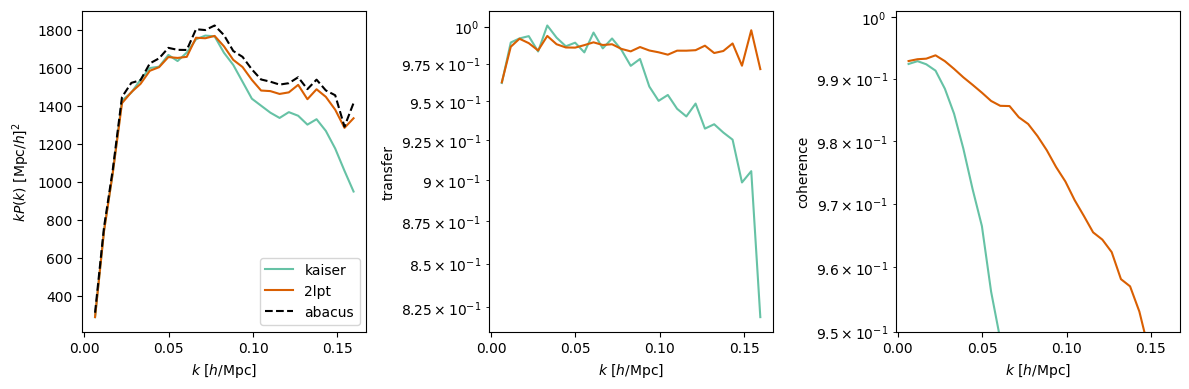

ell max: 308.85450532904366


In [9]:
from montecosmo.plot import plot_powtranscoh, plot_pow, plot_mesh, theme
from montecosmo.bricks import lin_power_interp
from montecosmo.nbody import a2chi
theme()

# labels = ['kaiser', '1lpt', '2lpt', 'pm']
labels = ['kaiser', '2lpt']
plt.figure(figsize=(12,4), layout='constrained')

for kptc, label in zip(kptcs, labels):
    plot_powtranscoh(*kptc, label=label)

plt.subplot(1,3,1)
# kpow_lin = kpow0[0], lin_power_interp(model.cosmo_fid, a=1/(1+z_obs))(kpow0[0])
# plot_pow(*kpow_lin, 'k:', label='linear')
plot_pow(*kpow0, 'k--', label='abacus')
plt.legend()
plt.subplot(1,3,3)
plt.ylim(0.95,1.001)
plt.tight_layout()
plt.show()

ell_max = kpow0[0][-1] * a2chi(model.cosmo_fid, a=1/(1+z_obs)) - 0.5
print("ell max:", ell_max)

/tmp/ipykernel_1865514/993061259.py:19: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


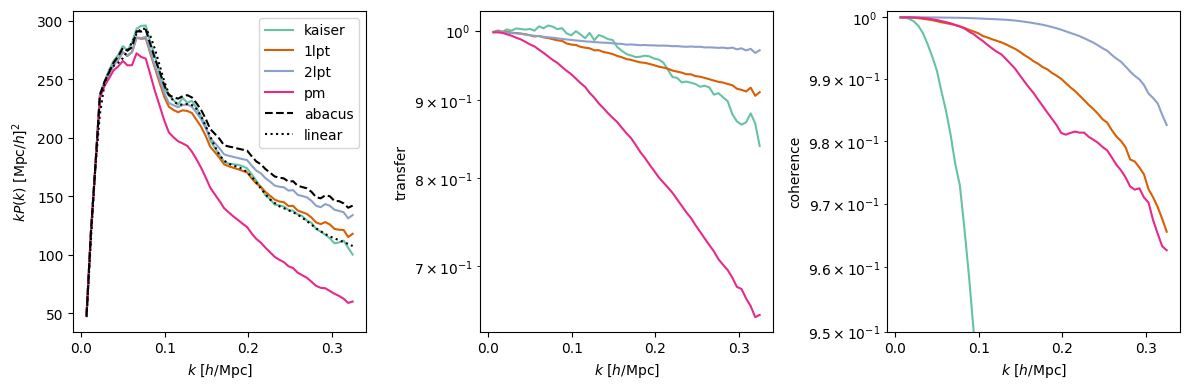

ell max: 629.2208507933007


In [ ]:
from montecosmo.plot import plot_powtranscoh, plot_pow, plot_mesh, theme
from montecosmo.bricks import lin_power_interp
from montecosmo.nbody import a2chi
theme()

labels = ['kaiser', '1lpt', '2lpt', 'pm']
plt.figure(figsize=(12,4), layout='constrained')

for kptc, label in zip(kptcs, labels):
    plot_powtranscoh(*kptc, label=label)

plt.subplot(1,3,1)
kpow_lin = kpow0[0], lin_power_interp(model.cosmo_fid, a=1/(1+z_obs))(kpow0[0])
plot_pow(*kpow0, 'k--', label='abacus')
plot_pow(*kpow_lin, 'k:', label='linear')
plt.legend()
plt.subplot(1,3,3)
plt.ylim(0.95,1.001)
plt.tight_layout()
plt.show()

ell_max = kpow0[0][-1] * a2chi(model.cosmo_fid, a=1/(1+z_obs)) - 0.5
print("ell max:", ell_max)

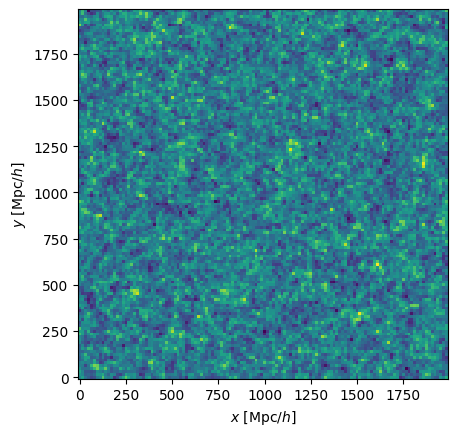

In [5]:
plot_mesh(sim['obs'], model.box_size)